<a href="https://colab.research.google.com/github/claree007/Housing-Prices/blob/master/Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>California Housing Prices</h1>

This is a regression problem which I have tackled using different ML models and here I compare their training time and accuracy. I have used Scikit-Learn and TensorFlow.




In [0]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

<h2>Loading the dataset</h2>

The dataset is already split into train and test set but it is the ratio 1:1. So I combine the 2 sets and then divide the whole set into train and test sets in the ratio 80 : 20 and then split the training set to make validation set in the ratio 20 : 80. The dataset is already clean and ready to train.

In [2]:
HOUSING_PATH = "sample_data"

def load_housing_data(file_name, housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, file_name)
    return pd.read_csv(csv_path)


housing_set1 = load_housing_data(file_name="california_housing_train.csv")
housing_set2 = load_housing_data(file_name="california_housing_test.csv")

housing = pd.concat([housing_set1, housing_set2], axis=0, ignore_index=True)

housing_X = housing.drop("median_house_value", axis=1)
housing_y = housing["median_house_value"].copy()

X_train, X_test, y_train, y_test = train_test_split(housing_X, housing_y, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_train_whole, y_train_whole, test_size=0.2)

print("Training set size:", X_train.shape)
#print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

housing.head()

Training set size: (16000, 8)
Test set size: (4000, 8)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Some visualizations of the dataset.

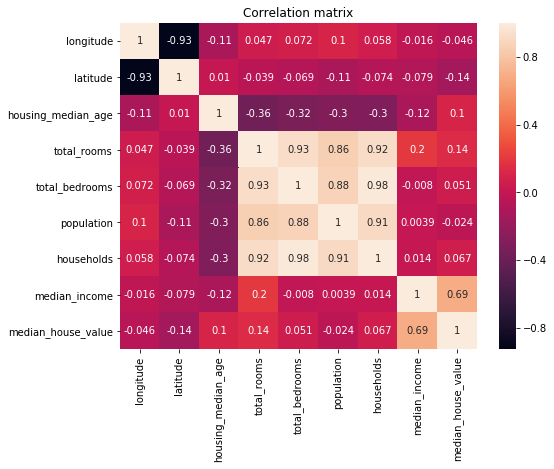

In [3]:
correlation = housing.corr()
fig = plt.figure(figsize=(8, 6))
plt.title("Correlation matrix")
fig = sns.heatmap(correlation, annot=True)

<h2>Preparing the dataset</h2>

In [0]:
rooms_ind, bedrooms_ind, population_ind, households_ind = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ind] / X[:, households_ind]
        population_per_household = X[:, population_ind] / X[:, households_ind]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ind] / X[:, rooms_ind]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

class AddBias(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, Y=None):
        return np.c_[np.ones((X.shape[0], 1)), X]


lin_reg_pipeline = Pipeline([
    ("comb_attr", CombinedAttributesAdder()),
    ("poly_features", PolynomialFeatures(degree=2, include_bias="False")),
    ("std_scaler", StandardScaler()),
    ("bias_adder", AddBias()),
])

# standardize and add bias to training set
X_train_bias = lin_reg_pipeline.fit_transform(X_train.values)

# standardize and add bias to validation set
#X_val_bias = lin_reg_pipeline.transform(X_val.values)


# to prevent some error
y_train = y_train.ravel().reshape(y_train.shape[0], 1)
#y_val = y_val.ravel().reshape(y_val.shape[0], 1)

<h2>Training</h2>

For each model, the best hyperparameters will searched and used. The fitting of each model during training is tested against a validation set. The lower the score, the better the fitting.

In [0]:
def learning_curve(model, X_train, y_train, X_val, y_val):
    train_error = []
    val_error = []
    m_train = len(X_train)
    m_val = len(X_val)
    
    if m_val <= m_train:
        m = m_val
    else:
        m = m_train
        
    for i in range(10, m+1):
        model.fit(X_train[:i], y_train[:i])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_error.append(mean_squared_error(y_train[:m], y_train_predict))
        val_error.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_error), "b-", linewidth=3, label="train")
    plt.plot(np.sqrt(val_error), "r-", label="val")
    plt.legend()
    plt.show()
    
    
def grid_search(model, param_grid={}):
    gs = GridSearchCV(model, param_grid, cv=3, scoring="neg_mean_squared_error",
                      error_score=0.0, return_train_score=True, refit=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X_train_bias, y_train)
    try:
        print(gs.best_estimator_)
        print("Best validation Score:", np.sqrt(abs(gs.best_score_)))
        #with open(type(model).__name__ + '.pickle', 'wb') as f:
        dump(gs.best_estimator_, type(model).__name__ + '.pickle')#pickle.dump(model, f)
        return gs.best_estimator_
    except:
        print("No model found!!")
        return model

<h3>Linear Regression</h3>

1. SVD

In [6]:
lin_reg = LinearRegression()
param_grid = {'normalize': [True, False]}

lin_reg = grid_search(lin_reg, param_grid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Best validation Score: 229734.86488515313


2. Batch Gradient Descent

In [7]:
class BatchGradientDescent(BaseEstimator, RegressorMixin):
    def __init__(self, lr=0.01, n_iterations=10000):
        self.lr = lr
        self.n_iterations = n_iterations
        self.intercept_ = None
        self.coef_ = None
        self.theta = None
        self.cost = np.array([])
        
    def gradient_descent(self, X, y, theta):
        m = X.shape[0]
        for iteration in range(self.n_iterations):
            err = np.subtract(X.dot(theta), y)
            self.cost = np.append(self.cost, (1 / (2 * m)) * np.sum(np.square(err)))
            gradient = (1 / m) * (X.T.dot(err))
            theta = theta - (self.lr * gradient)
        return theta
        
    def fit(self, X, y=None, theta=None):
        if theta == None:
            self.theta = np.random.randn(X.shape[1], 1)
        else:
            self.theta = theta
        self.theta = self.gradient_descent(X, y, self.theta)
        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]
        
    def predict(self, X):
        try:
            return X.dot(self.theta)
        except Exception as e:
            print(e)
            return "Run the fit method first"
        
    def score(self, X, y):
        # counts number of values bigger than mean
        u = sum((y - self.predict(X))**2.0)
        v = sum((y - y.mean())**2.0)
        return 1.0 - (u / v)
        
bgd = BatchGradientDescent()
param_grid = {}

bgd = grid_search(bgd, param_grid)

BatchGradientDescent(lr=0.01, n_iterations=10000)
Best validation Score: 69851.14346401927


3. Stochastic Gradient Descent

In [8]:
sgd_reg = SGDRegressor()
param_grid = {'loss': ['squared_loss', 'squared_epsilon_insensitive', 'huber'],
              'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.1, 0.03, 0.003],
              'l1_ratio': [0.5, 0.3], 'max_iter': [2000], 'eta0': [0.01, 0.1],
              'learning_rate': ['adaptive', 'constant', 'optimal', 'invscaling'], 'power_t': [0.1, 0.01],
              'early_stopping': [True], 'epsilon': [0.01, 0.1]}

sgd_reg = grid_search(sgd_reg, param_grid)

SGDRegressor(alpha=0.003, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.5,
             learning_rate='adaptive', loss='huber', max_iter=2000,
             n_iter_no_change=5, penalty='l1', power_t=0.01, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
Best validation Score: 149301.33196738642


4. Ridge Regression

In [0]:
ridge_reg = Ridge()
param_grid = {'alpha': [10.0, 15.0, 20.0], 'normalize': [True, False], 'max_iter': [1000, 2000],
              'solver': ['cholesky', 'lsqr', 'sag', 'saga'], 'tol': [1e-5]}

ridge_reg = grid_search(ridge_reg, param_grid)

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=2000,
      normalize=False, random_state=None, solver='saga', tol=1e-05)
Best validation Score: 65283.09770391636


5. Lasso Regression

In [0]:
lasso_reg = Lasso()
param_grid = {'alpha': [0.5, 1.0, 2.0], 'normalize': [True, False],
              'max_iter': [1000, 2000], 'warm_start': [True, False]}

lasso_reg = grid_search(lasso_reg, param_grid)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=True)
Best validation Score: 66228.33292208609


6. Elastic Net

In [0]:
elastic_net = ElasticNet()
param_grid = {'alpha': [0.2, 0.5, 1.0, 2.0], 'normalize': [True, False],
              'max_iter': [1000, 2000], 'warm_start': [True, False], 'l1_ratio': [0.1, 0.3, 0.5]}

elastic_net = grid_search(elastic_net, param_grid)

ElasticNet(alpha=0.2, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=2000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=True)
Best validation Score: 67534.15857706146


7. Decision Tree

In [0]:
dt_reg = DecisionTreeRegressor()
param_grid = {'criterion': ['mse', 'mae'], 'splitter': ['best', 'random'], 
              'max_depth': [20, 30], 'min_samples_split': [6, 10],
              'min_samples_leaf': [2, 4], 'min_weight_fraction_leaf': [0.01, 0.1],
              'max_features': [0.5, 0.7, 1.0], 'presort': [True]}

dt_reg = grid_search(dt_reg, param_grid)

DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=0.5,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.01,
                      presort=True, random_state=None, splitter='best')
Best validation Score: 66054.67250575518


8. SVM

In [0]:
svr_reg = SVR()
param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
              'degree': [1, 2], 'gamma': [0.1, 0.01], 'coef0': [0.1, 0.01], 
              'tol': [1e-5], 'C': [0.5, 1.0, 2.0], 'epsilon': [0.1, 0.01], 
              'max_iter': [2000]}

svr_reg = grid_search(svr_reg, param_grid)

SVR(C=2.0, cache_size=200, coef0=0.1, degree=1, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=2000, shrinking=True, tol=1e-05, verbose=False)
Best validation Score: 117169.88970219147


<h2>Testing</h2>

Running the best models trained through grid search on the test set.

In [0]:
models = []
model_names = ['LinearRegression', 'BatchGradientDescent', 'SGDRegressor', 
               'Ridge', 'Lasso', 'ElasticNet', 'DecisionTreeRegressor', 'SVR']

# load models from saved pickle file
for name in model_names:
    try:
        with open(name + '.pickle', 'rb') as f:
            model = load(f)
            print(model)
            #model.fit(X_train_bias, y_train)
            models.append(model)
    except:
        pass

# test models on test data
X_test = lin_reg_pipeline.transform(X_test.values)

for model in models:
    print(type(model).__name__)
    y_predict = model.predict(X_test)
    print("Score:", np.sqrt(mean_squared_error(y_test, y_predict)))
    print('\n')

Comparing with Random Forests Classifier which is an ensemble method.

In [0]:
rf_reg = RandomForestRegressor()
param_grid = {'n_estimators': [100], 'min_samples_split': [4],
              'min_samples_leaf': [4], 'bootstrap': [True], 'n_jobs': [-1],
              'warm_start': [False]}

rf_reg = grid_search(rf_reg, param_grid)
y_predict = rf_reg.predict(X_test)
print("Score:", np.sqrt(mean_squared_error(y_test, y_predict)))

<h2>Conclusion</h2>